# Filament detection and segmentation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage.morphology import skeletonize as skel 
from skimage.morphology import disk
from scipy import interpolate
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import imageio as iio
import scipy.ndimage as ndi

### To-do
From https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980
- try active contour segmentation
- try Random walker segmentation
- unsupervised learning

Special care for edges!

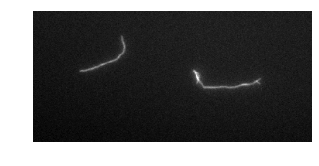

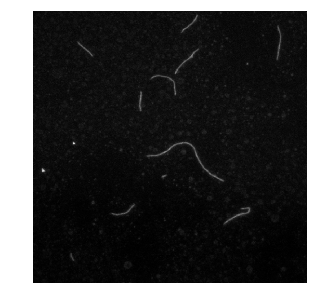

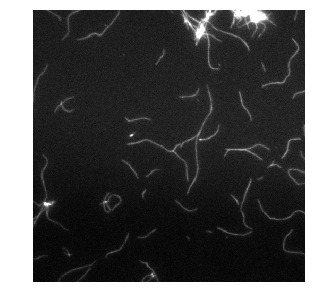

In [52]:
im = iio.imread('2fil.PNG')
im = color.rgb2gray(im) 

multi = iio.imread('multifil.PNG')
multi = color.rgb2gray(multi)
def im_show(image, nrows=1, ncols=1, cmap='gray', title = ''):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.set_title(title, loc='center')
    ax.axis('off')
    return fig, ax

dx5 = iio.imread('Dx5-2 20nM 100%labelled wBSA_Thu Apr 11 2019_15.54.14.tif')
dx5 = color.rgb2gray(dx5)
im_show(im)
im_show(multi)
im_show(dx5)
im = dx5

## Heat map with colour bar NOT USEFULL

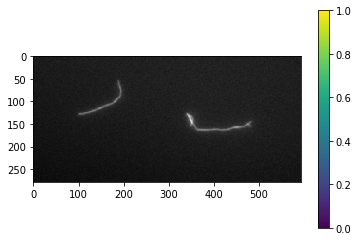

In [60]:
plt.imshow(im, vmin = 0, vmax = 1)
plt.colorbar()

In [7]:
#Trying to get the image in a better format so cv can process it
im = iio.imread('2fil.PNG')
im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(im)

NameError: name 'cv2' is not defined

In [47]:
im = dx5

In [7]:
im

array([[41, 48, 54, ..., 54, 53, 58],
       [56, 53, 47, ..., 50, 56, 59],
       [46, 50, 50, ..., 49, 60, 53],
       ...,
       [32, 31, 35, ..., 38, 37, 34],
       [36, 33, 35, ..., 35, 38, 31],
       [34, 37, 37, ..., 36, 37, 33]], dtype=uint8)

# 1st approach: basic thresholding

In [53]:
fig, ax = plt.subplots(1, 1)
ax.hist(im.ravel(), bins=255, range=[0,255])
ax.set_xlim(0, 255);
ax.set_title('Histogram of intensities', loc = 'center')
plt.savefig('histogram_intensities.PNG', dpi = 100)
plt.clf()

<Figure size 432x288 with 0 Axes>

### Supervised Thresholding

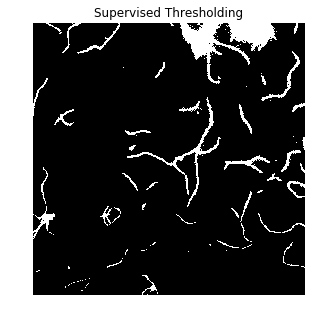

In [71]:
mask = np.where(im < 70, 0, 255)
im_show(mask, title = 'Supervised Thresholding')
plt.savefig('thresholding_supervised.PNG', dpi=150)

In [5]:
#plt.imshow(ndi.binary_closing(mask, iterations=2))

### Unsupervised Thresholding
Tons of options to try!

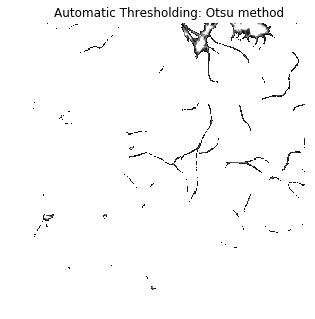

In [69]:
im_threshold = filters.threshold_otsu(im)  
im_show(np.where(im > im_threshold, im, np.NaN), title = 'Automatic Thresholding: Otsu method')
plt.savefig('thresholding_automatic_otsu.PNG', dpi=150)

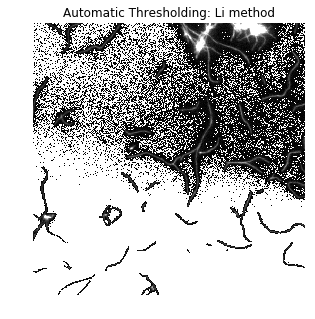

In [70]:
im_threshold = filters.threshold_li(im)  
im2 = np.where(im > im_threshold, im, np.NaN)
im_show(im2, title = 'Automatic Thresholding: Li method')
plt.savefig('thresholding_automatic_li.PNG', dpi=150)

In [33]:
im_threshold = filters.hessian(im)  
im3 = np.where(im > im_threshold, im, np.NaN)
im_show(im3)
plt.clf()

<Figure size 1008x1008 with 0 Axes>

## Own thresholding algorithm 

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20a73616b00>)

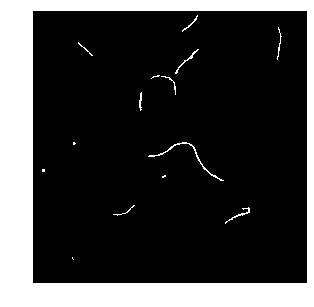

In [66]:
#Experimenting to get a better final image

#idea that the interface could have slidebars to adjust image processing
def pre_processing_dark(multi):    
    #thresholding, masking, filtering
    masked_multi = np.where(multi < np.percentile(multi, 99),0 , multi)
    mask_dilate = ndi.binary_dilation(masked_multi, iterations=1)
    mask_erosion = ndi.binary_erosion(mask_dilate, iterations=2)
    mask_closed = ndi.binary_closing(mask_erosion, iterations=3)
    mask_median = filters.median(mask_closed, disk(2.5))
    multi_final = mask_median
    
    return multi_final

def pre_processing_bright(multi):    
    #thresholding, masking, filtering
    masked_multi = np.where(multi < np.percentile(multi, 94),0 , multi)
    mask_dilate = ndi.binary_dilation(masked_multi, iterations=3)
    mask_erosion = ndi.binary_erosion(mask_dilate, iterations=2)
    mask_closed = ndi.binary_closing(mask_erosion, iterations=2)
    mask_median = filters.median(mask_closed, disk(1.5))
    multi_final = mask_median
    
    return multi_final

def pre_processing_general(multi):    
    #thresholding, masking, filteri
    multi = normalize(multi, norm='l1')
    multi = np.where(multi < np.percentile(multi, 95),0 , multi)
    multi = ndi.binary_dilation(multi, iterations=2)
    multi = ndi.binary_erosion(multi, iterations=1)
    multi = ndi.binary_opening(multi, iterations=1)
    multi_final = multi
    
    return multi_final

multi_final = pre_processing_dark(multi)
im_show(multi_final)

In [67]:
imfinal = pre_processing_general(im)
im_show(im, title='Our own automatic thresholding algorithm')

NameError: name 'normalize' is not defined

## Once we have the processed image

In [11]:
#to see how labels work
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html
labels, nobjects = ndi.label(multi_final)
nobjects

14

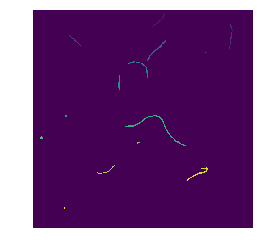

In [12]:
plt.imshow(labels)
plt.axis('off')
plt.show()

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131a0e4ebe0>)

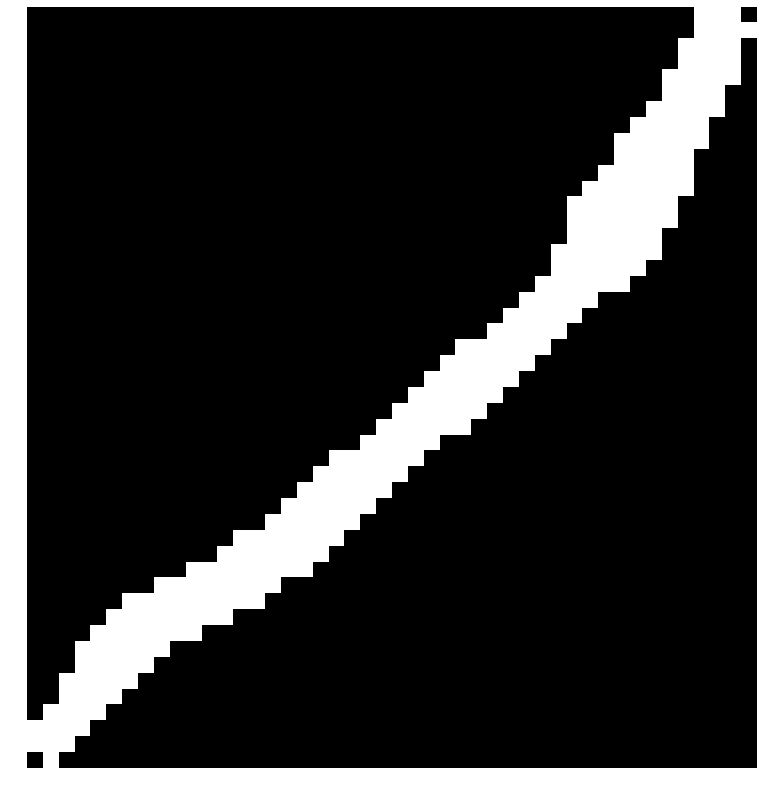

In [13]:
boxes = ndi.find_objects(labels)
object_0 = multi_final[boxes[0]]
object_1 = multi_final[boxes[1]]
im_show(object_0)
#plt.savefig('masked_single_fil.png')

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1319baa7438>)

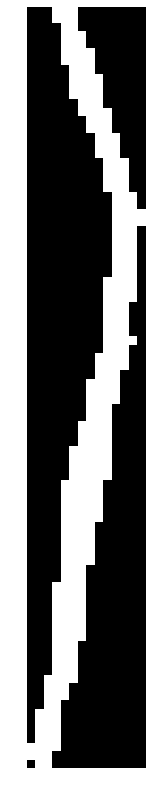

In [14]:
im_show(object_1)

In [1]:
#leaving out the small parts
objects = [np.array(multi_final[boxes[i]]) for i in range(0,nobjects-1) if (np.array(multi_final[boxes[i]]).shape[0]*np.array(multi_final[boxes[i]]).shape[1] > 600)]

for i in objects[5,7]:
    im_show(i)

NameError: name 'nobjects' is not defined

In [34]:
range(10,20)[2]

12

We want to only have one object in each picture so we'll build a function that set's every pixel to black but the largest connected object. This will not only take care of the small dots that survived the pre processing but also will make it possible to analyze two filaments even when they are very close to each other.

In [26]:
#VERSION FOR SINGLE OBJECT
#def simplifying(object):
#    #first part is to get labels and boxes 
#    labels, nobs = ndi.label(object)
#    boxes = ndi.find_objects(labels)
#   
#    #if there is only one object then no need to modify the picture
#    if len(boxes)>1:
#        #Then we have to compare their size and get the index of the biggest one
#        obs = [np.array(object[boxes[i]]) for i in range(0,nobs)]
#        obs_sizes = [ob.shape[0]*ob.shape[1] for ob in obs]
#        n = int(np.where(obs_sizes == np.max(obs_sizes))[0])
#
#
#        #now follows the mask that will filter everything but the biggest
#
#        for i in range(1,nobjects):
#            if i != n:
#                object[boxes[i]].fill(0)
#    return object 


def singlify(list_of_objects):
    for single_object in list_of_objects:
        #first part is to get labels and boxes on each single object
        labels, nobs = ndi.label(single_object)
        boxes = ndi.find_objects(labels)

        #if there is only one object then no need to modify the picture
        if nobs>1: #if we have two or more objects 
            #Then we have to compare their size and get the index of the biggest one
            obs = [np.array(single_object[boxes[i]]) for i in range(0,nobs)]
            obs_sizes = [ob.shape[0]*ob.shape[1] for ob in obs]
            n = int(np.where(obs_sizes == np.max(obs_sizes))[0])

            #now follows the mask that will filter everything but the biggest
    
            for i in range(0,nobs):
                if i != n:
                    single_object[boxes[i]].fill(0)
    return list_of_objects 
singles =  singlify(objects)

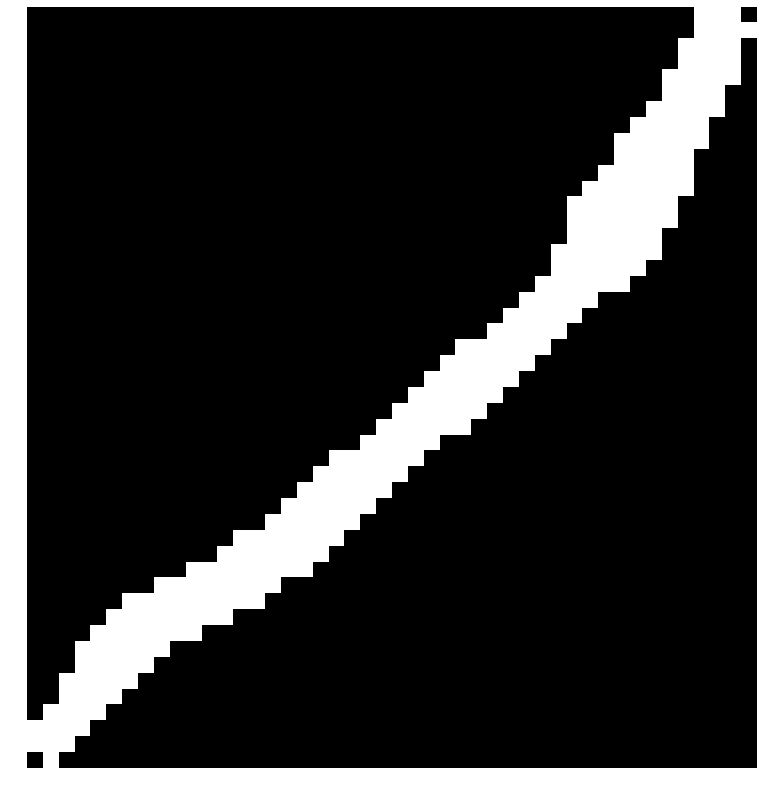

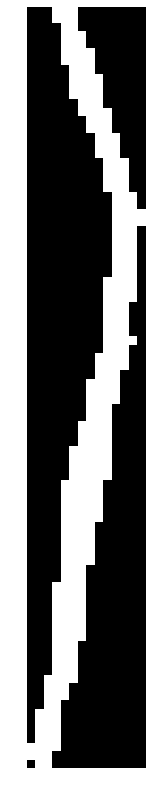

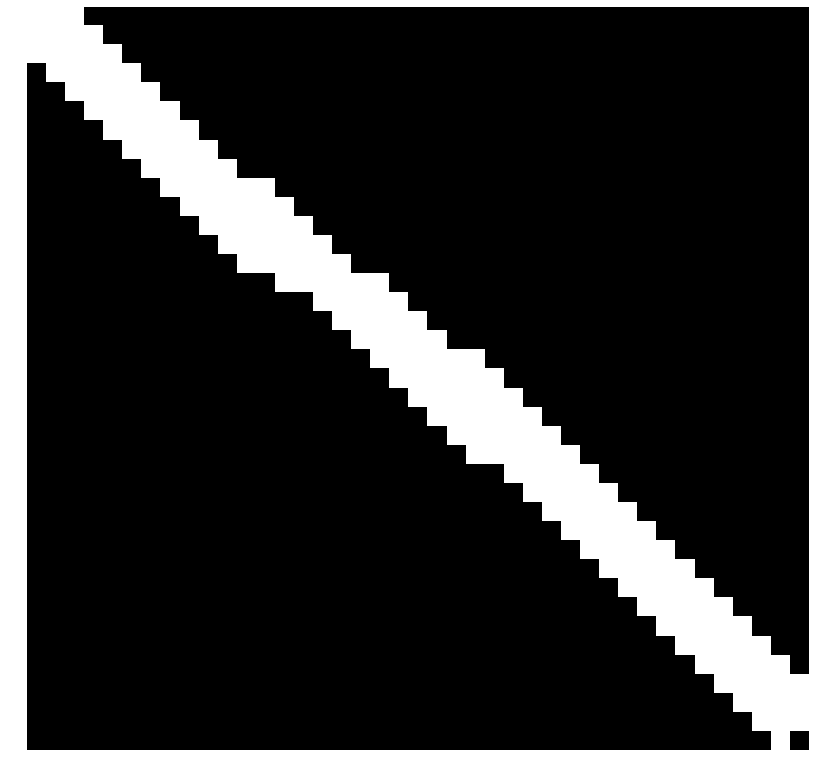

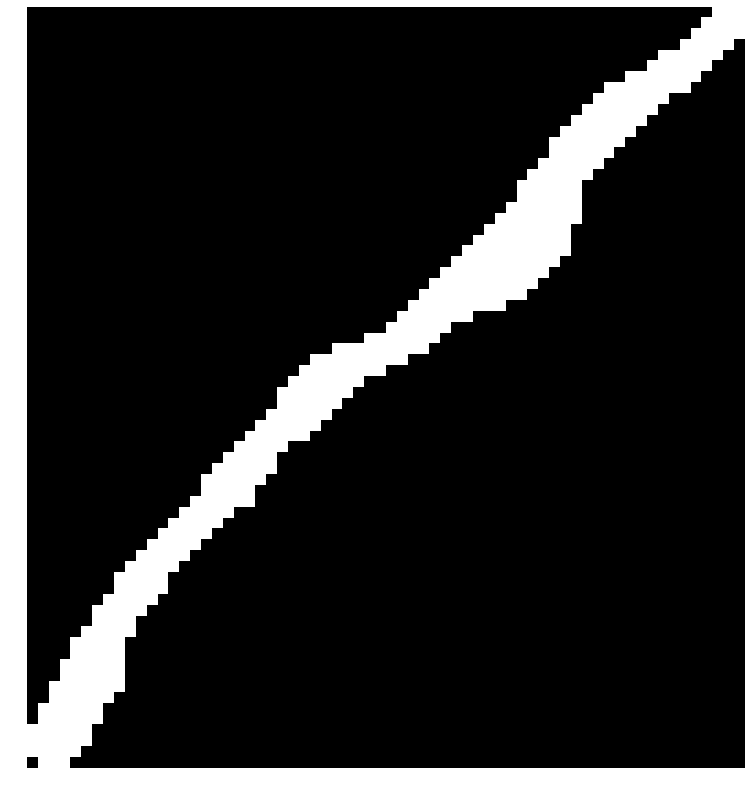

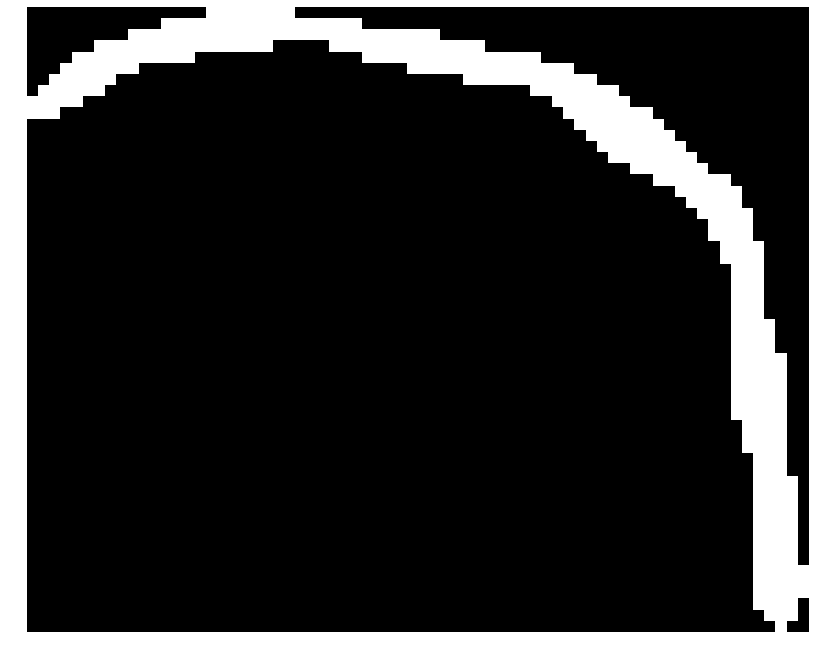

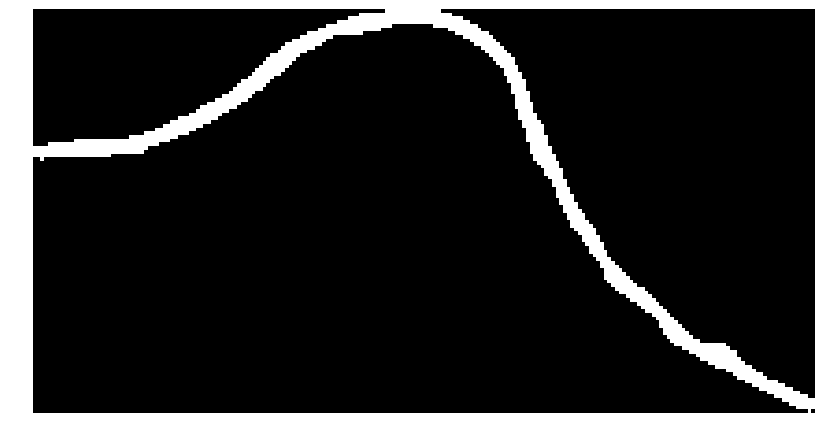

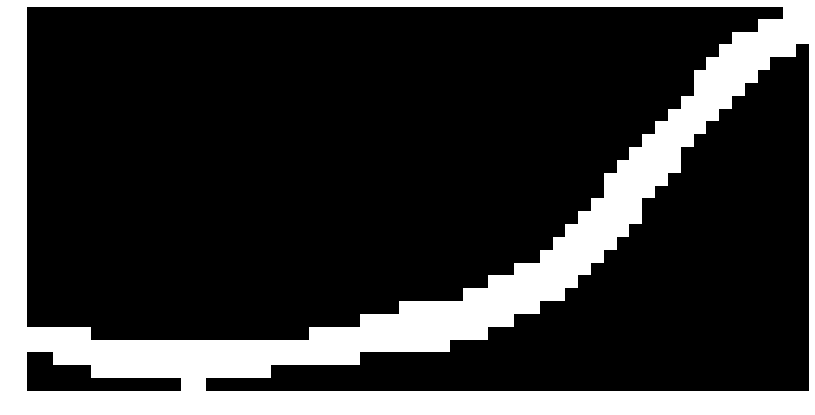

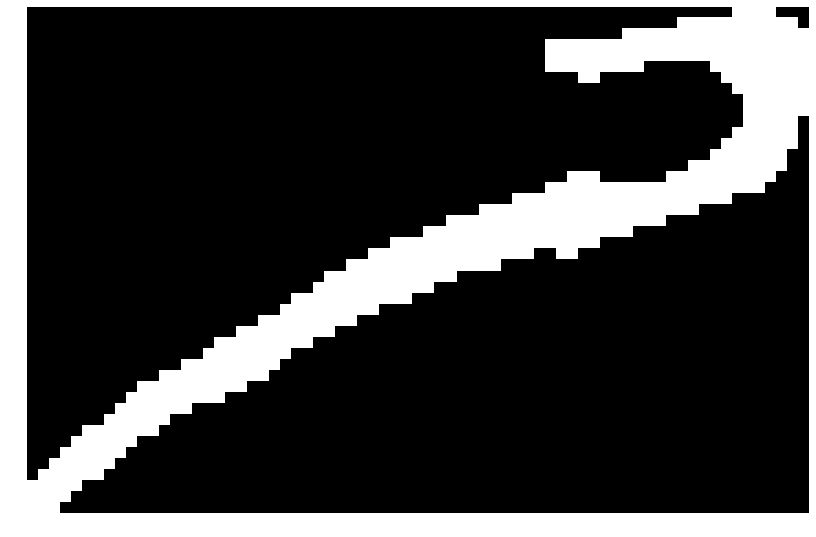

In [27]:
for i in singles:
    im_show(i)

### Test with another image

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12153a2c4e0>)

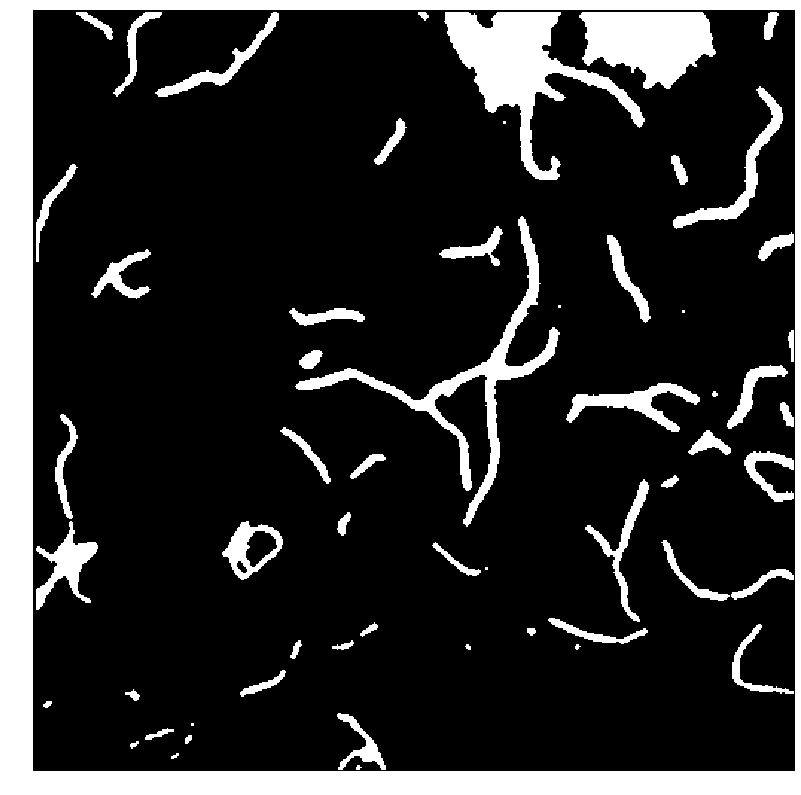

In [12]:
dx5 = iio.imread('Dx5-2 20nM 100%labelled wBSA_Thu Apr 11 2019_15.54.14.tif')
dx5 = color.rgb2gray(dx5)
dx5_final = pre_processing_bright(dx5)
im_show(dx5_final)

# Trying skeleton function to get backbone

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131a1db5630>)

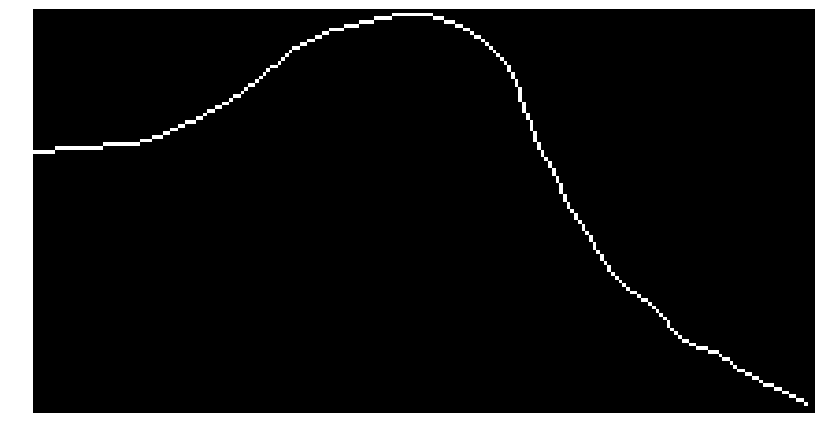

In [28]:
test_object = np.where(singles[5] >0, 1, 0)
test_output = skel(test_object)
im_show(skel(test_object))

## From output image to output coordinates

In [29]:
#the idea is to get first an arrays like [(x1,y1), (x2, y2), ...]
locations = np.where(test_output==True)
coords = [[locations[0][i], locations[1][i]] for i in range(0, len(locations[0]))]
#this actually outputs something like (yi, xi) and with y from bigger to smaller
# ordering the output
ordered = sorted(coords, key=lambda k: [k[1], k[0]])
ordered = [np.flip(x) for x in ordered]
coords = ordered
#now to match JFils format
f = open("snake.txt", "w+")
f.write("#\r")
f.write("0\r")
for i in range(0, len(coords)):
    f.write("1\t"+ str(i) + "\t" + "%d\t" % (coords[i][0]) + "%d\t" % (coords[i][1]) + "0\r")
f.close()

# Getting fit 

In [185]:
#trying polynomial fit up to 10th degree
x = [coords[i][0] for i in range(0, len(coords))]
y = [coords[i][1] for i in range(0, len(coords))]

#poly coeffs
#z = np.polyfit(x,y,10)
#poly function
#p = np.poly1d(z)
#plt.plot(x,y,'ro', x, p(x), 'b', markersize=1)

#Not impressed
#Now using spline interpolation\
#converting x to arange to be able to use InterpolatedUnivariateSpline
x = np.arange(np.min(x), np.max(x)+1, 1)
ius =InterpolatedUnivariateSpline(x,y)
#xspline = np.arange(np.min(x),np.max(x), 200)
#yspline= s(xspline)

#plt.plot(xspline, yspline, 'b', markersize=2)

error: failed in converting 2nd argument `y' of dfitpack.fpcurf0 to C/Fortran array

# ------------------------------------------------

# Creating backbone function

In [129]:
def backbone(objects):
    binaries = [np.where(ob > 0, 1, 0) for ob in objects]
    backbones = [skel(binary) for binary in binaries]
    binary_backbones = [np.where(ob ==True, 1, 0) for ob in backbones]
    return binary_backbones
backbones = backbone(singles)

In [134]:
global x
x=5
def changex():
    x=4
x
changex()
x

5

In [108]:
skel(np.where(objects[0] > 0, 1, 0))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [70]:
#TEST
objects_final= [backbone(ob) for ob in singles]
objects_final

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False,  Tr

# Creating overlaping image single+backbone

In [101]:
def greyoverlap(singles, backbones):
    greyoverlap = [np.where(backbones[i] == 1, -80, 0) + singles[i] for i in range(0, len(singles))]
    return greyoverlap

final_images= greyoverlap(singles, backbones)

## Now we have individual filaments to analyse

In [15]:
def backbone_detection(im):
    r, c = im.shape
    maxs = []
    for i in range(r):
        maxs.append([i, np.argmax(im[i])])
    backbone = np.zeros([r,c])
    for i in range(r):
        for j in range(c):
            if j == maxs[i][1]:
                backbone[i][j] = 1
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(im)
    ax[1].imshow(backbone)
    plt.show()

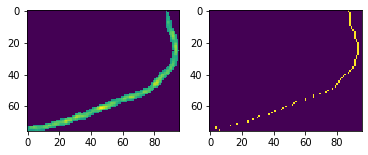

In [16]:
backbone_detection(object_0)

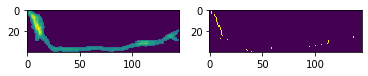

In [17]:
backbone_detection(object_1)

In [18]:
def backbone_detection2(im):
    imt = im.transpose()
    r, c = im.shape
    maxs1 = []
    maxs2 = []
    for i in range(r):
        maxs1.append([i, np.argmax(im[i])])
    for i in range(c):
        maxs2.append([i, np.argmax(imt[i])])
    backbone1 = np.zeros([r,c])
    backbone2 = np.zeros([c, r])
    for i in range(r):
        for j in range(c):
            if j == maxs1[i][1]:
                backbone1[i][j] = 1
    for i in range(c):
        for j in range(r):
            if j == maxs2[i][1]:
                backbone2[i][j] = 1
    backbone = backbone1 + backbone2.transpose()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[1].imshow(backbone)
    ax[1].axis('off')
    plt.show()

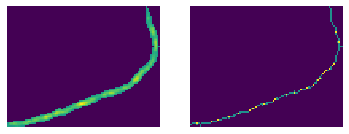

In [19]:
backbone_detection2(object_0)

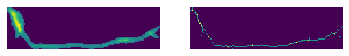

In [20]:
backbone_detection2(object_1)

## Assuming backbone = middle

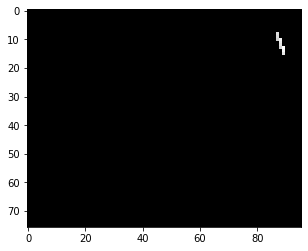

In [78]:
im = object_0
#framing image
im[0,:] =0
im[:,0] =0
im[-1,:] =0
im[:, -1] =0
plt.imshow(im,cmap='gray')

- idea will be to scan the whole picture row by row and saving in an array the individual arrays that are non zeros
- then for each of these non zero chunks deal with three cases: only one pixel, odd n of pixels, even n of pixels
- once we finally got the point of interest save it and plot the ensemble
- will probably have to do the same colum-wise to avoid same mistake as last time

In [22]:
#first let's try with a single row
#we see that row 30 has 2 chunks so good to work with
#from np.argwhere we know that we are looking for an output = [16, 21, 102, 129]
row = im[25]
np.argwhere(row)

array([[  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [131],
       [132],
       [133],
       [134],
       [135],
       [136],
       [137],
       [138],
       [139]])

In [23]:
#this block should return the argument of the points in the row belonging to the backbone
#version with brightness included
'''
points = []
for i in parts:
    if i.size == 1:
        points.append(i[0])
    elif i.size % 2 == 0:
        k = np.int(i.size/2)
        if chunks[i][k] <= chunks[i][k+1]:
            points.append(i[k+1])
        else:
            points.append(i[k])
    else:
        k = np.int(math.floor(i.size/2))
        points.append(i[k])
points = np.array(points)
points
'''
#version taking simply floor
inside_points = []
for i in parts:
    if i.size == 1:
        inside_points.append(i[0])
    elif i.size % 2 == 0:
        k = np.int(i.size/2)
        inside_points.append(i[k])
    else:
        k = np.int(math.floor(i.size/2))
        inside_points.append(i[k])
#inside_points = np.array(inside_points)
inside_points


NameError: name 'parts' is not defined

In [ ]:
#doing it for all rows
back_bone_points = []

#going through all rows
for j in range(im.shape[0]):
    row = im[j]
    breaks = []
    
    #finding breaking points
    for i in range(row.size-1):
        if (row[i] != 0  and  row[i-1] == 0) or (row[i] != 0 and row[i+1] == 0):
            breaks.append(i)     
    #breaks = np.array(breaks)
    
    #in case no bright pixel in row (frames)
    if breaks != []:
        
        #finds/generates slides of data from the info given in the breaks
        parts = []
        for i in np.arange(0, len(breaks)-1, 2):
            parts.append(np.arange(breaks[i], breaks[i+1]+1))
        parts = np.array(parts)

        chunks=[]
        for i in np.arange(0, len(breaks)-1, 2):
            chunks.append(row[breaks[i]: breaks[i+1]+1])
        chunks = np.array(chunks)
        
       #find middle or important point in those slides
       #version taking simply floor
        inside_points = []
        
        #checking every slide
        for i in parts:
            
            #if only one pixel in that part
            #worth taking it?
            if i.size == 1:
                inside_points.append(i[0])
            
            #if even number of pixels brightness or floor applied
            elif i.size % 2 == 0:
                k = np.int(math.floor(i.size/2))
                inside_points.append(i[k])
            
            #off number of pixels take middle one
            else:
                k = np.int(math.floor(i.size/2))
                inside_points.append(i[k])
        #inside_points = np.array(inside_points)
        back_bone_points.append(inside_points)

#creating proper list of points
def_points = []
for i in range(len(back_bone_points)):
    for j in back_bone_points[i]:
        def_points.append((i, j))

#creating image with def_points
r, c = im.shape
backbone1 = np.zeros([r,c])
for point in def_points:
    backbone1[point[0]][point[1]] = 1

plt.imshow(backbone1)
plt.axis('off')

In [ ]:
im = np.transpose(im)
plt.imshow(im)

In [ ]:
#now doing that for all columns
back_bone_points = [] 
#going through all rows
for j in range(im.shape[0]):
    row = im[j]
    breaks = []
    
    #finding breaking points
    for i in range(row.size-1):
        if (row[i] != 0  and  row[i-1] == 0) or (row[i] != 0 and row[i+1] == 0):
            breaks.append(i)     
    #breaks = np.array(breaks)
    
    #in case no bright pixel in row (frames)
    if breaks != []:
        
        #finds/generates slides of data from the info given in the breaks
        parts = []
        for i in np.arange(0, len(breaks)-1, 2):
            parts.append(np.arange(breaks[i], breaks[i+1]+1))
        parts = np.array(parts)

        chunks=[]
        for i in np.arange(0, len(breaks)-1, 2):
            chunks.append(row[breaks[i]: breaks[i+1]+1])
        chunks = np.array(chunks)
        
       #find middle or important point in those slides
       #version taking simply floor
        inside_points = []
        
        #checking every slide
        for i in parts:
            
            #if only one pixel in that part
            #worth taking it?
            if i.size == 1:
                inside_points.append(i[0])
            
            #if even number of pixels brightness or floor applied
            elif i.size % 2 == 0:
                k = np.int(math.floor(i.size/2))
                inside_points.append(i[k])
            
            #off number of pixels take middle one
            else:
                k = np.int(math.floor(i.size/2))
                inside_points.append(i[k])
        #inside_points = np.array(inside_points)
        back_bone_points.append(inside_points)

#creating proper list of points
def_points = []
for i in range(len(back_bone_points)):
    for j in back_bone_points[i]:
        def_points.append((i, j))

#creating image with def_points
r, c = im.shape
backbone2 = np.zeros([r,c])
for point in def_points:
    backbone2[point[0]][point[1]] = 1
backbone2=np.transpose(backbone2)
plt.imshow(backbone2)
plt.axis('off')

In [ ]:
plt.imshow(backbone1+backbone2)

# Trying to get middle by tunning the mask

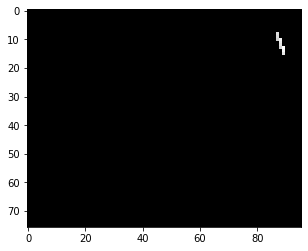

In [77]:
im = object_0
plt.imshow(im,cmap='gray')

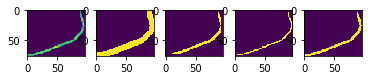

In [48]:
# Create and tune mask
mask_dilate = ndi.binary_dilation(im, iterations=3)
mask_closed = ndi.binary_closing(im, iterations=3)
mask_erosion = ndi.binary_erosion(im, iterations=1)
mask_opening = ndi.binary_opening(im, iterations=1)
# Plot masked images
fig, axes = plt.subplots(1,5)
axes[0].imshow(im)
axes[1].imshow(mask_dilate)
axes[2].imshow(mask_closed)
axes[3].imshow(mask_erosion)
axes[4].imshow(mask_opening)
#format_and_render_plot()
plt.show()

Erosion looks like the best option but still it is too intense

# Getting middle by deleting intensity from left and right 

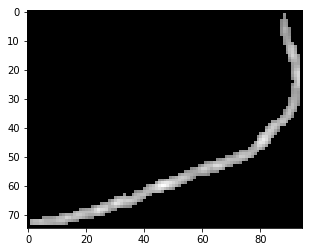

In [140]:
im = np.copy(object_0)
#framing image
im[0,:] =0
im[:,0] =0
im[-1,:] =0
im[:, -1] =0
plt.imshow(im,cmap='gray')

In [141]:
def get_middle(im):
    r, c = im.shape
    for i in range(r-1):
        if len(np.where(x)[0]) > 1:
            for j in range(c-1):
                if ((im[i][j] != 0) and (im[i+1][j+1] == 0)):
                    im[i][j] = 0
            
    plt.imshow(im)

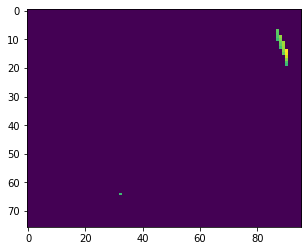

In [128]:
get_middle(im)

# new idea for checking 'good' filaments
- Mask to have black and white
- get contour
- get points with high convexity
- if more than two then not nice filament
- also add size check to get rid of very small ones

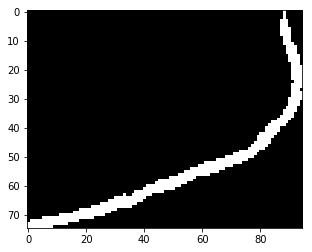

In [167]:
#to replace all non background pixels with white ones
im = np.copy(object_0)
im[im != 0] = 1
plt.imshow(im, cmap = 'gray')

In [204]:
#getting contour using opencv
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
#im = np.uint8(im)
image, cnt, hierarchy = cv2.findContours(im,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

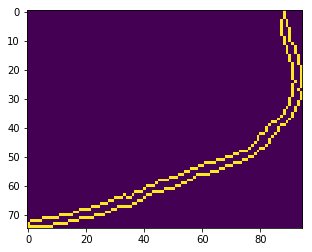

In [205]:
image = cv2.drawContours(image, cnt, 0, (70,0,0), 1)
plt.imshow(image)

### To check convexity points we have to draw the hull first and then find the points of the contour with minimum local deviations from the hull.
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html

In [206]:
hull = cv2.convexHull(cnt[0], returnPoints = False)
#now how to unpack those points?

In [208]:
defects = cv2.convexityDefects(cnt[0],hull)
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    cv2.line(img,start,end,[0,255,0],2)
    cv2.circle(img,far,5,[0,0,255],-1)
cv2.imshow('img',img)


IndexError: list index out of range

In [201]:
#difference between contour and hull
diff = np.sqrt(contours[])

SyntaxError: invalid syntax (<ipython-input-201-5405f660f3a7>, line 2)